# supernode-clustering

The procedure of supernode clustering with respect to various feature sets.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/infrastructure_features.json`
3. `data/features/graph_features.json`

Produces:
1. `data/clustering/supernode_clusters.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.linalg import LinAlgError
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from myutils.json import save_json

from ptn.cluster_analysis import kmeans_inertia, dmdbscan, match_clusters, plot_clusters, \
    plot_separate_clusters, plot_cluster_features
from config import supernodes_fpath, infrastructure_features_fpath, graph_features_fpath, \
    supernode_clusters_fpath

plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('deep'))

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [4]:
coords = supernodes[['lon', 'lat']]

coords.head(2)

,lon,lat
id,,
0,30.322415,59.85171
1,30.287937,59.95021


In [5]:
infrastructure_features = pd.read_json(infrastructure_features_fpath).set_index('id')

total = infrastructure_features['total']
infrastructure_features = infrastructure_features.drop(columns=['total'])

infrastructure_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,Administrative,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre
id,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,0.013311,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,0.030050,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0


In [6]:
infr_mask = total > 0

(~infr_mask).sum()

84

In [7]:
infrastructure_features.notna().all().all()

True

In [8]:
graph_features = pd.read_json(graph_features_fpath).set_index('id')

graph_features = graph_features.dropna(axis=1)

connected = graph_features['connected']
graph_features = graph_features.drop(columns=['connected'])

graph_features -= graph_features.min()
graph_features /= graph_features.max() - graph_features.min()

graph_features.head(2)

,betweenness_centrality,closeness_centrality_hops,closeness_centrality_weight,clustering,degree_centrality,pagerank
id,,,,,,
0,1.000000,0.971249,0.939782,0.000000,0.817805,0.943609
1,0.130699,0.855255,0.945213,0.107925,0.513458,0.520381


In [9]:
graph_mask = connected.astype(bool)

(~graph_mask).sum()

17

In [10]:
graph_features.notna().all().all()

True

## Clustering

### Infrastructure

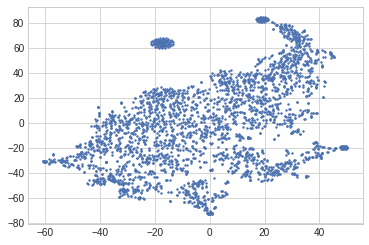

In [11]:
tsne = TSNE(random_state=0).fit_transform(infrastructure_features.values)
tsne = pd.DataFrame(tsne, index=infrastructure_features.index)

plt.scatter(*tsne.values.T, s=2)

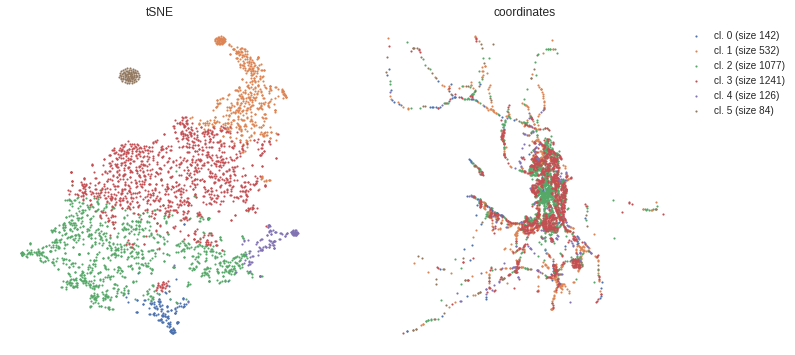

In [12]:
clusters_ = KMeans(n_clusters=5, random_state=0).fit_predict(infrastructure_features[infr_mask])

# clusters_ = DBSCAN(eps=0.2).fit_predict(infrastructure_features[infr_mask])
# clusters_[clusters_ == -1] = clusters_.max() + 1

infrastructure_clusters = pd.Series(clusters_.max() + 1, index=infrastructure_features.index)
infrastructure_clusters[infr_mask] = clusters_

plot_clusters(infrastructure_clusters, tsne, coords)

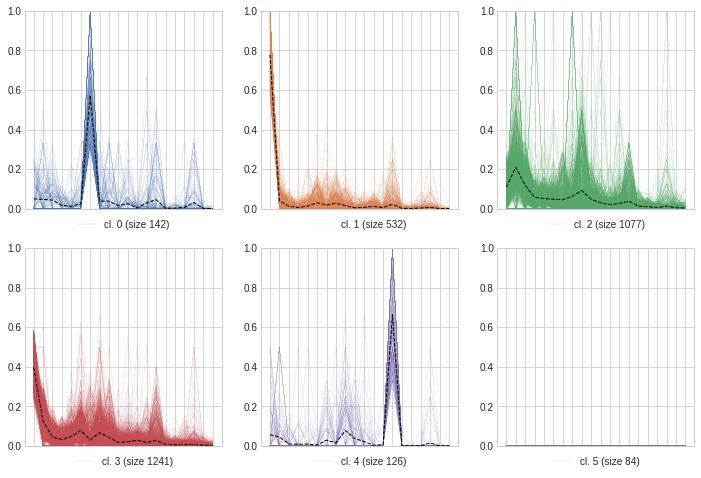

In [13]:
plot_separate_clusters(
    features=infrastructure_features,
    clusters=infrastructure_clusters,
)

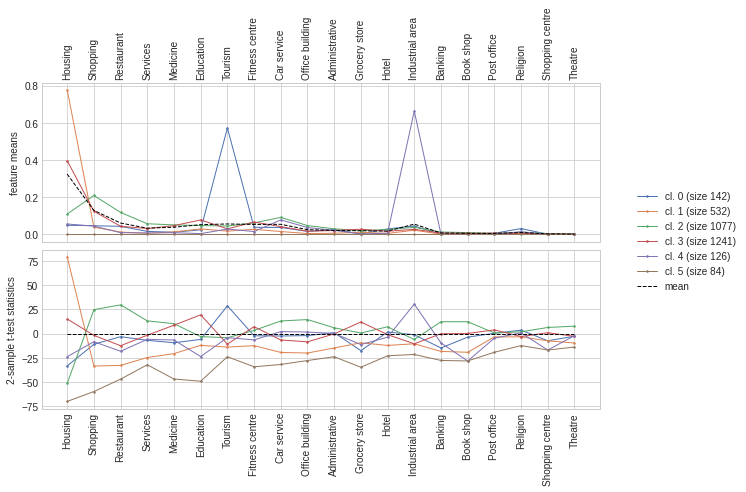

In [14]:
plot_cluster_features(
    features=infrastructure_features,
    clusters=infrastructure_clusters,
)

The 5 clusters can be interpreted as follows:

* Mainly tourist areas: tourism, restaurants, not much else (~140)
* "Good" residential areas: housing with schools, hospitals, shops nearby (~1240)
* "Bad" residential areas: housing with pretty much nothing nearby (~530)
* Industrial areas, fuel stations, other car-related stuff (~125)
* City center: not much housing, mainly shops, restaurants, services, banks etc. (~1070)

Additionally, we have a separate "cluster" of supernodes with no infrastructure objects around (~85).

__Warning!__ The following cluster numbering can differ if you run the code above on a different machine.

In [50]:
infrastructure_cluster_names = {
    2: 'city_center',
    3: 'residential_area_good',
    4: 'industrial_area',
    0: 'tourism_area',
    1: 'residential_area_bad',
    5: 'infrastructureless_area',
}

In [51]:
def plot_total_by_cluster(
        total: pd.Series,
        clusters: pd.Series,
):
    for i in sorted(clusters.unique()):
        mask = clusters == i
        cluster_size = mask.sum()

        cluster_total = total[mask]

        ox = np.linspace(cluster_total.min(), cluster_total.max(), 500)

        try:
            oy = stats.gaussian_kde(cluster_total)(ox)
        except LinAlgError:
            pass
        else:
            plt.plot(ox, oy, c=f'C{i}', label=f'cl. {i} (size {cluster_size})')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

(0.0, 150.0)

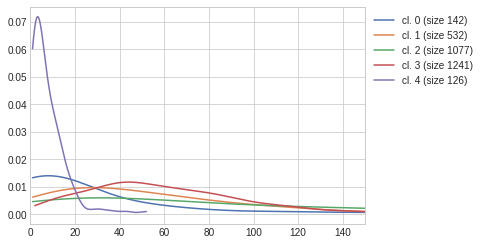

In [52]:
plot_total_by_cluster(total, infrastructure_clusters)

plt.xlim(0, 150)
# plt.xscale('log')

"Industrial" stops on average have the smallest number (less than 20) of infrastructure objects around them. Tourism-related and "bad residential" stops follow with about 35-45 objects, "good residential" stops get around 40-50 objects, and the largest number of objects connects to the central stops (90-110). Note that the number of objects around a stop was not used in clustering (only fractions of various kinds of objects), so such correspondence seems reasonable.

In [53]:
clusters = pd.DataFrame({'infr_cl': infrastructure_clusters})
clusters['infr_cl_name'] = clusters['infr_cl'].apply(infrastructure_cluster_names.get)

clusters.head(2)

,infr_cl,infr_cl_name
id,,
0,2,city_center
1,2,city_center


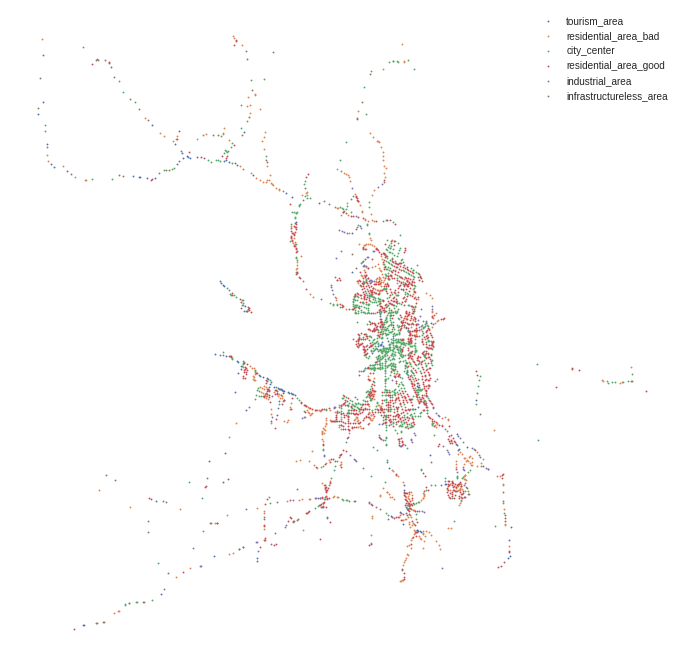

In [54]:
plt.figure(figsize=(12, 12))
plt.gca().axis('off')

for i in sorted(clusters['infr_cl'].unique()):
    ids = clusters.loc[clusters['infr_cl'] == i].index
    cluster_coords = coords.loc[ids, ['lon', 'lat']].values
    
    plt.scatter(*cluster_coords.T, color=f'C{i}', marker='.', s=3,
                label=infrastructure_cluster_names[i])
    
plt.legend()

### Topology

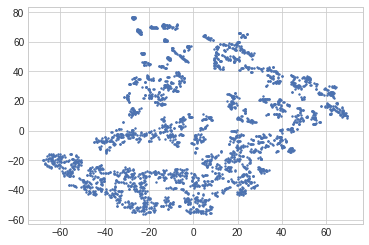

In [20]:
tsne = TSNE(random_state=0).fit_transform(graph_features.values)
tsne = pd.DataFrame(tsne, index=graph_features.index)

plt.scatter(*tsne.values.T, s=2)

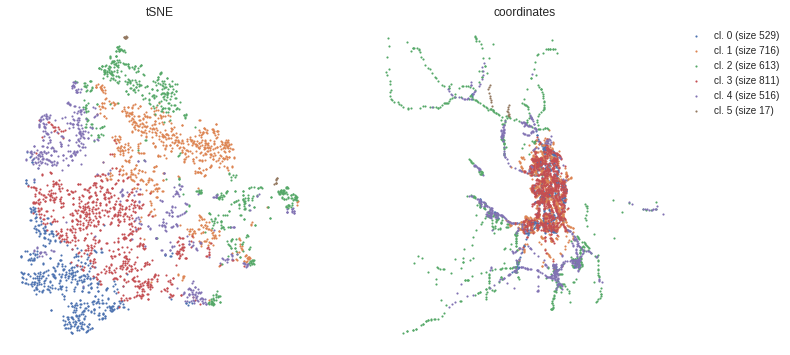

In [41]:
clusters_ = KMeans(n_clusters=5, random_state=0).fit_predict(graph_features[graph_mask])

# clusters_ = DBSCAN(eps=0.012).fit_predict(graph_features[graph_mask])
# clusters_[clusters_ == -1] = clusters_.max() + 1

graph_clusters = pd.Series(clusters_.max() + 1, index=graph_features.index)
graph_clusters[graph_mask] = clusters_

plot_clusters(graph_clusters, tsne, coords)

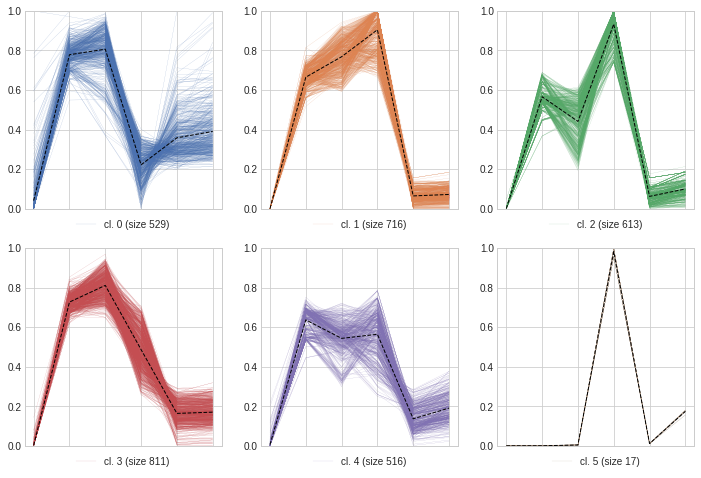

In [42]:
plot_separate_clusters(
    features=graph_features,
    clusters=graph_clusters,
)

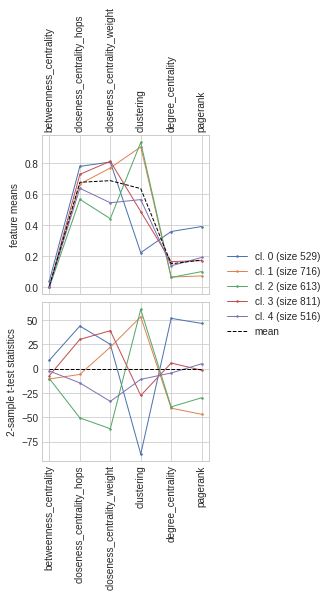

In [43]:
plot_cluster_features(
    features=graph_features[graph_mask],
    clusters=graph_clusters[graph_mask],
)

In [55]:
graph_cluster_names = {
    0: 'hub',
    3: 'center',
    1: 'inaccessible_center',
    4: 'suburbs',
    2: 'outskirts',
}

In [56]:
clusters['graph_cl'] = graph_clusters
clusters['graph_cl_name'] = clusters['graph_cl'].apply(graph_cluster_names.get)

clusters.head(2)

,infr_cl,infr_cl_name,graph_cl,graph_cl_name
id,,,,
0,2,city_center,0,hub
1,2,city_center,0,hub


In [57]:
contingency_table = clusters.copy()
contingency_table['count'] = 1

contingency_table = contingency_table\
    .groupby(['infr_cl_name', 'graph_cl_name'])['count'].sum().reset_index()\
    .pivot(index='infr_cl_name', columns='graph_cl_name', values='count').fillna(0)

contingency_table

graph_cl_name,center,hub,inaccessible_center,outskirts,suburbs
infr_cl_name,,,,,
city_center,322.0,253.0,286.0,113.0,100.0
industrial_area,11.0,0.0,38.0,48.0,29.0
infrastructureless_area,0.0,0.0,3.0,65.0,13.0
residential_area_bad,59.0,27.0,98.0,196.0,143.0
residential_area_good,402.0,242.0,279.0,136.0,180.0
tourism_area,17.0,7.0,12.0,55.0,51.0


### Concatenated features

In [58]:
features = pd.concat([infrastructure_features, graph_features], axis=1)

features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Post office,Religion,Shopping centre,Theatre,betweenness_centrality,closeness_centrality_hops,closeness_centrality_weight,clustering,degree_centrality,pagerank
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.006656,0.000000,0.000000,0.0,1.000000,0.971249,0.939782,0.000000,0.817805,0.943609
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.006678,0.011686,0.001669,0.0,0.130699,0.855255,0.945213,0.107925,0.513458,0.520381


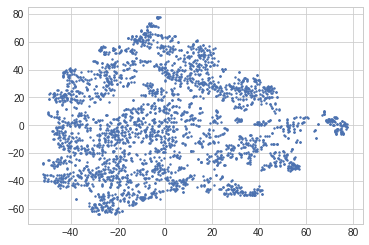

In [59]:
tsne = TSNE(random_state=0).fit_transform(features.values)
tsne = pd.DataFrame(tsne, index=features.index)

plt.scatter(*tsne.values.T, s=2)

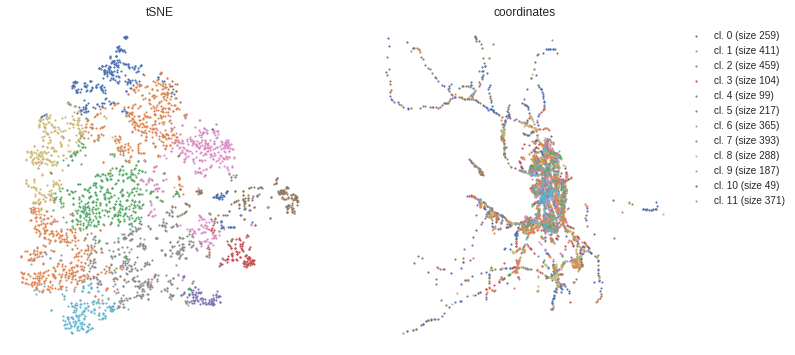

In [60]:
clusters_ = KMeans(n_clusters=12, random_state=0).fit_predict(features)

consensus_clusters = pd.Series(clusters_, index=features.index)

plot_clusters(consensus_clusters, tsne, coords)

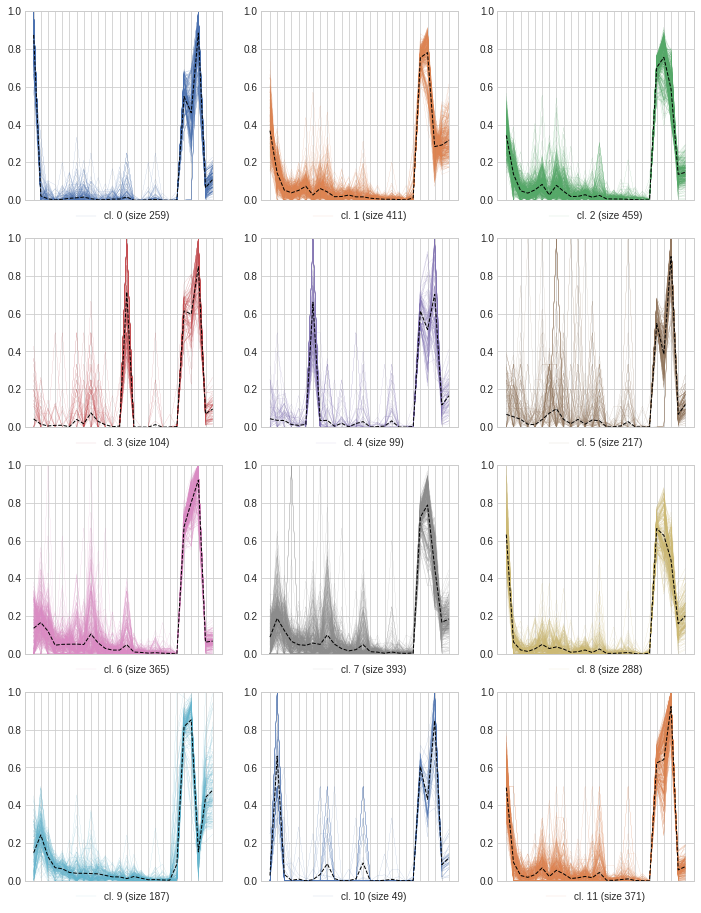

In [61]:
plot_separate_clusters(
    features=features,
    clusters=consensus_clusters,
)

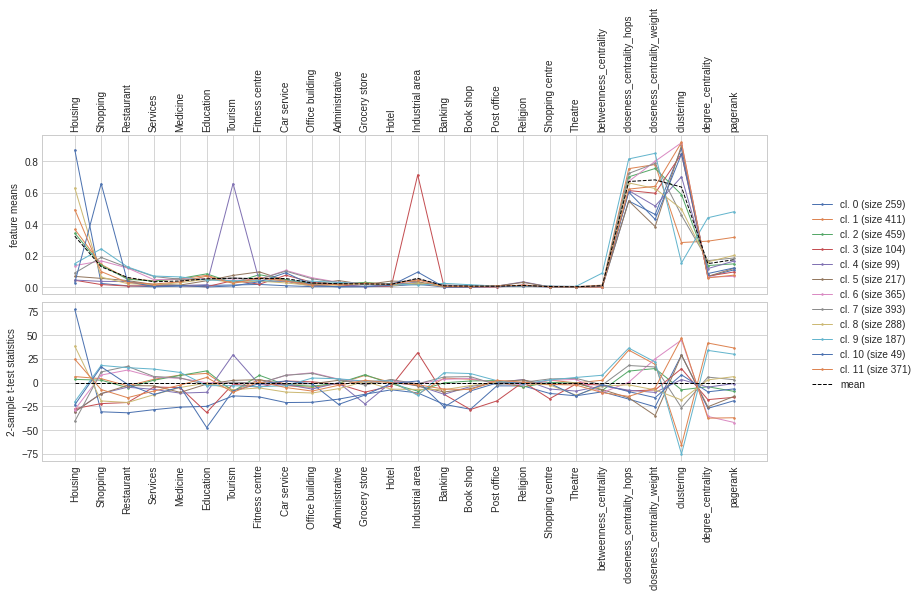

In [62]:
plot_cluster_features(
    features=features,
    clusters=consensus_clusters,
)

In [63]:
clusters['consensus_cl'] = consensus_clusters

clusters.head(2)

,infr_cl,infr_cl_name,graph_cl,graph_cl_name,consensus_cl
id,,,,,
0,2,city_center,0,hub,9
1,2,city_center,0,hub,9


In [64]:
contingency_table = clusters.copy()

contingency_table['infr_graph_cl'] = contingency_table['infr_cl_name'] + '+' \
    + contingency_table['graph_cl_name']

contingency_table['count'] = 1

contingency_table = contingency_table\
    .groupby(['infr_graph_cl', 'consensus_cl'])['count'].sum().reset_index()\
    .pivot(index='infr_graph_cl', columns='consensus_cl', values='count').fillna(0)

contingency_table

consensus_cl,0,1,2,3,4,5,6,7,8,9,10,11
infr_graph_cl,,,,,,,,,,,,
city_center+center,0.0,12.0,40.0,0.0,0.0,0.0,6.0,264.0,0.0,0.0,0.0,0.0
city_center+hub,0.0,59.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,156.0,0.0,0.0
city_center+inaccessible_center,0.0,0.0,9.0,0.0,0.0,0.0,275.0,0.0,0.0,0.0,2.0,0.0
city_center+outskirts,0.0,0.0,0.0,0.0,0.0,72.0,10.0,0.0,0.0,0.0,30.0,1.0
city_center+suburbs,0.0,1.0,9.0,0.0,0.0,12.0,4.0,64.0,0.0,0.0,10.0,0.0
industrial_area+center,0.0,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
industrial_area+inaccessible_center,0.0,0.0,0.0,32.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0
industrial_area+outskirts,0.0,0.0,0.0,41.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0
industrial_area+suburbs,0.0,0.0,0.0,23.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0


In [65]:
clusters_json = []

for i, row in clusters.iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    clusters_json.append(item)
    
clusters_json[0]

{'id': 0,
 'infr_cl': 2,
 'infr_cl_name': 'city_center',
 'graph_cl': 0,
 'graph_cl_name': 'hub',
 'consensus_cl': 9}

In [66]:
save_json(clusters_json, supernode_clusters_fpath)